# 0. Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
os.chdir('../dataset')

# 1. Set parameters

In [3]:
# set parameters
categories = os.listdir()

# 2. Load data

In [4]:
def read_txt(filename):
    file = open(filename, 'r', encoding='latin1')
    txt = file.read()
    
    return txt

def read_category(category):
    filename_list = []
    txt_list = []
    txt_len_list = []
    
    file_list = os.listdir(category)
    for file in file_list:
        filename = os.path.join(category, file)
        txt = read_txt(filename)
        filename_list.append(filename.replace('/', '_'))
        txt_list.append(txt)
        txt_len_list.append(len(txt))
        
    dic = {
        'category': [category]*len(filename_list),
        'filename': filename_list,
        'raw_text': txt_list,
        'raw_text_lenght': txt_len_list
    }
    return pd.DataFrame.from_dict(dic)

def load_data():
    data = pd.DataFrame()
    for category in categories:
        new_data = read_category(category)
        data = data.append(new_data)
        
    return data

In [5]:
data = load_data()
data = data.reset_index(drop=True)
data.index.name = 'id'
data.head()

,category,filename,raw_text,raw_text_lenght
id,,,,
0,headhunters,headhunters_38282,\n hi guys\n like all people in this group i'm...,806
1,headhunters,headhunters_38475,"\n\nHi! Everyone,\n\nBecause no one has touche...",1835
2,headhunters,headhunters_37916,\n I recently got a file describing a l...,506
3,headhunters,headhunters_38601,"\n\nIn article <C5tK4u.C6t@cs.columbia.edu>, y...",451
4,headhunters,headhunters_38462,\nIn article <1993Apr19.141034.24731@sctc.com>...,5894


# 3. Exploratory Data Analysis

In [6]:
df_cat = data['category'].value_counts().reset_index()

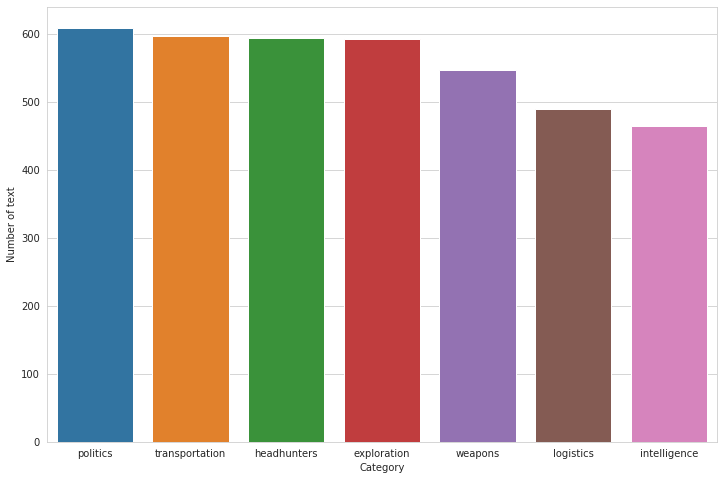

In [7]:
# Number of text per category
plt.figure(figsize=(12,8))
sns.barplot(x=df_cat['index'], y=df_cat.category)
plt.xlabel('Category')
plt.ylabel('Number of text')
plt.show()

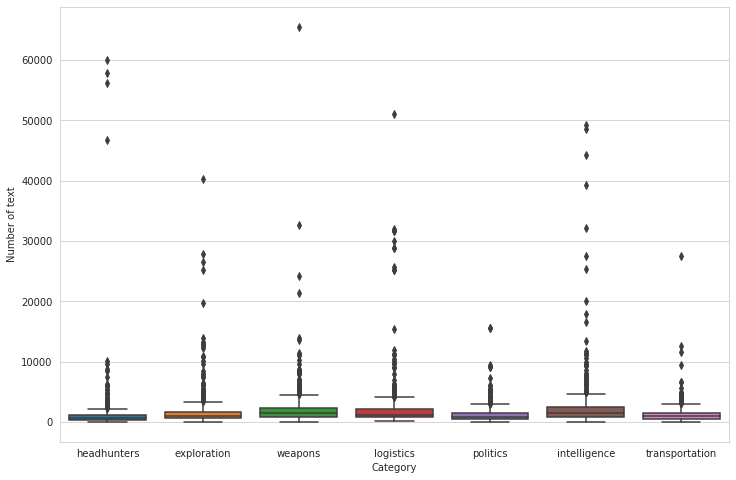

In [8]:
# Length of text distribution per category
plt.figure(figsize=(12,8))
sns.boxplot(x=data.category, y=data.raw_text_lenght)
plt.xlabel('Category')
plt.ylabel('Number of text')
plt.show()

In [9]:
data.loc[data.raw_text_lenght==data.raw_text_lenght.max(), 'raw_text']

id
1327    \n\nTry the firearms archive.  Larry Cipriani'...
Name: raw_text, dtype: object

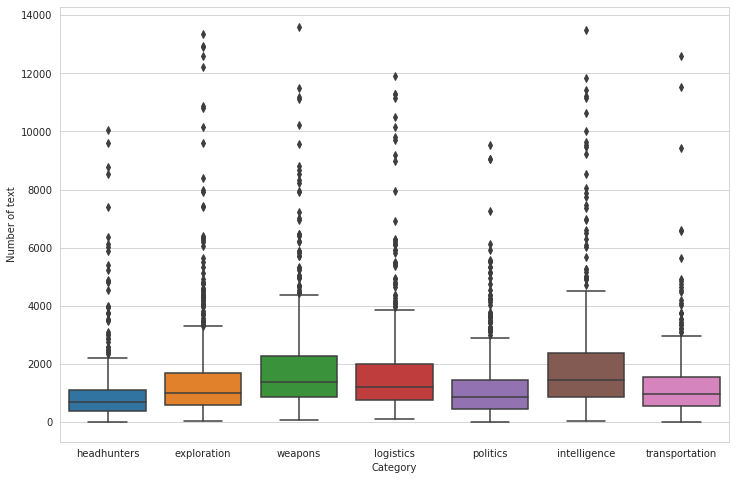

In [10]:
# Length of text distribution per category cutting of 1% of largest ones
p99 = np.percentile(data.raw_text_lenght, 99)
data99 = data[data.raw_text_lenght<=p99]
plt.figure(figsize=(12,8))
sns.boxplot(x=data99.category, y=data99.raw_text_lenght)
plt.xlabel('Category')
plt.ylabel('Number of text')
plt.show()

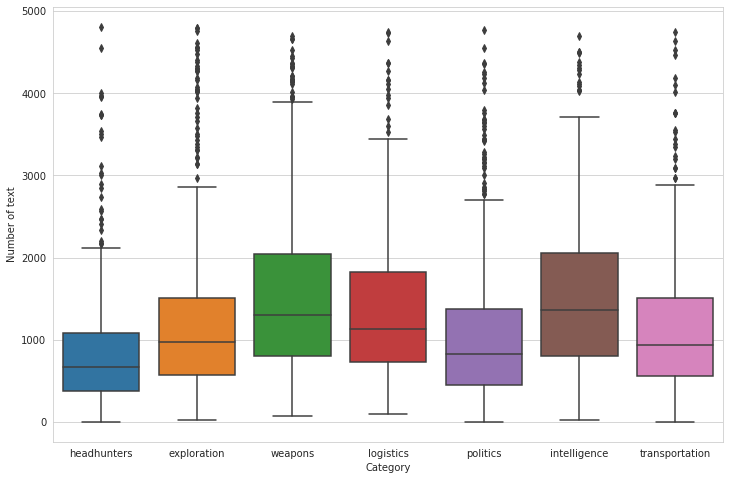

In [11]:
# Length of text distribution pero category cutting of 5% of largest ones
p95 = np.percentile(data.raw_text_lenght, 95)
data95 = data[data.raw_text_lenght<=p95]
plt.figure(figsize=(12,8))
sns.boxplot(x=data95.category, y=data95.raw_text_lenght)
plt.xlabel('Category')
plt.ylabel('Number of text')
plt.show()

# 4. Data cleaning

In [12]:
# Replace \r and \n
data['text_1'] = data['raw_text'].str.replace("\r", " ")
data['text_1'] = data['text_1'].str.replace("\n", " ")
data['text_1'] = data['text_1'].str.replace("\t", " ")
data['text_1'] = data['text_1'].str.strip()

In [13]:
# " when quoting text
data['text_1'] = data['text_1'].str.replace('"', '')

In [14]:
# Lowercasing the text
data['text_2'] = data['text_1'].str.lower()

In [15]:
# puntuaction signs
punctuation_signs = list("?:!.,;@--<>")
data['text_3'] = data['text_2']

for punct_sign in punctuation_signs:
    data['text_3'] = data['text_3'].str.replace(punct_sign, ' ')
data['text_3'] = data['text_3'].str.strip()

# 5. Lemmatize

In [16]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to /home/dario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dario/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
nrows = len(data)
lemmatized_text_list = []

for row, fln in zip(range(0, nrows), data['filename']):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = data.loc[data['filename']==fln]['text_3'][row]
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [19]:
data['text_4'] = lemmatized_text_list

# 6. Stopwords

In [20]:
# Downloading the stop words list
nltk.download('stopwords')

# Loading the stop words in english
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some words usually appear for several categories so we in our context we may treat them as extra stopwords

In [21]:
add_stopwords = ['edu', 'com', 'article', 'write', 'get', 'would']
stop_words = stop_words+add_stopwords

In [22]:
for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    data['text_4'] = data['text_4'].str.replace(regex_stopword, '')

In [23]:
data.loc[data['filename']=='headhunters_37916']['text_4'][2]

" recently   file describe  library  render routines  call sipp (simple polygon processor)   could anyone tell      ftp  source code     newest version around          also  ' never use renderman    wonder  renderman   like sipp   ie   library  render routines  one use  make   program  create  image                                             thank   joe tham     joe tham              joth ersys edmonton ab ca"

In [24]:
data['text_4'] = data['text_4'].apply(lambda text: re.sub(' +', ' ', text))

# 7. Set label

In [25]:
cat_dic = dict(zip(categories, list(range(len(categories)))))

In [26]:
data['category_label'] = data['category'].map(cat_dic)
data = data[['category', 'filename', 'raw_text', 'text_4', 'category_label']]
data.head()

,category,filename,raw_text,text_4,category_label
id,,,,,
0,headhunters,headhunters_38282,\n hi guys\n like all people in this group i'm...,hi guy like people group ' fan fractal render ...,0
1,headhunters,headhunters_38475,"\n\nHi! Everyone,\n\nBecause no one has touche...",hi everyone one touch problem post last week g...,0
2,headhunters,headhunters_37916,\n I recently got a file describing a l...,recently file describe library render routine...,0
3,headhunters,headhunters_38601,"\n\nIn article <C5tK4u.C6t@cs.columbia.edu>, y...",c5tk4u c6t cs columbia ykim cs columbia (yong...,0
4,headhunters,headhunters_38462,\nIn article <1993Apr19.141034.24731@sctc.com>...,1993apr19 141034 24731 sctc boebert sctc (ear...,0


# 8. Train - Test

We select just 15% for testing because there is no much data and we want our model to train with as much data as possible. Other possibility is train with crossvalidation and we will be able to test over all dataset but I keep it simple here.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text_4'], 
    data['category'], 
    test_size=0.15, 
    random_state=8
)

# 9. Features based on CountVectorizer for text representation

At this point we create features for text based on counting how many words appears in each text over all words in all texts. Although this metric emphasize more on larger texts, it still interesting. Also those text which are larger are well-distibuted over all categories as we saw in point 3. 

In [28]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

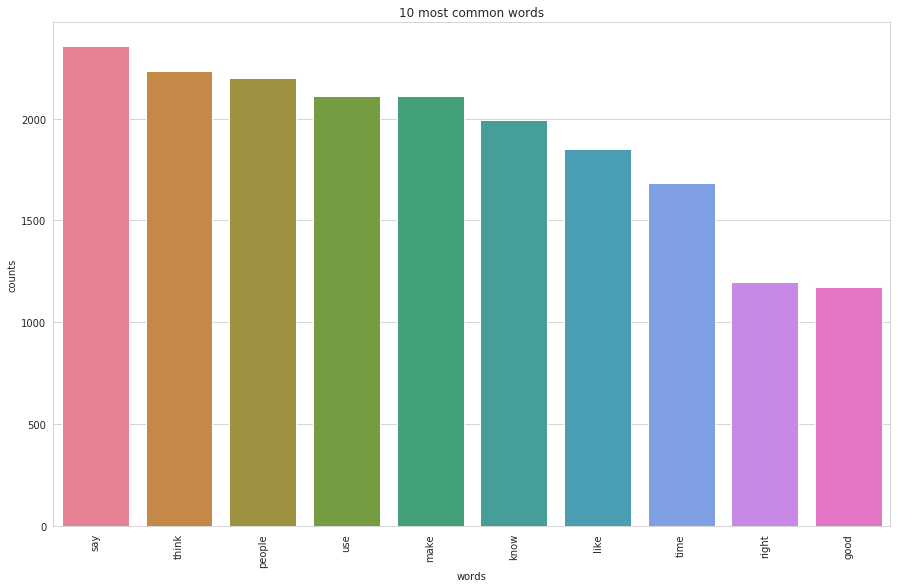

In [29]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(X_train)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Now we are going to try multiple models. We could try a lot more includind neural networks but let see this three: logistic regression, random forest and naive bayes

## 9.1. Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(count_data, y_train)
test_count_data = count_vectorizer.transform(X_test)

score = classifier.score(test_count_data, y_test)
test_scores = classifier.predict(test_count_data)

print("Accuracy: {:.2f}%".format(score*100))

Accuracy: 94.69%


In [34]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)]
    y_test_cat = y_test[y_test.index.isin(idx)]
    test_count_data = count_vectorizer.transform(X_test_cat)

    score = classifier.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 98.95%
Accuracy on exploration: 90.24%
Accuracy on weapons: 92.94%
Accuracy on logistics: 94.67%
Accuracy on politics: 98.98%
Accuracy on intelligence: 91.67%
Accuracy on transportation: 93.51%


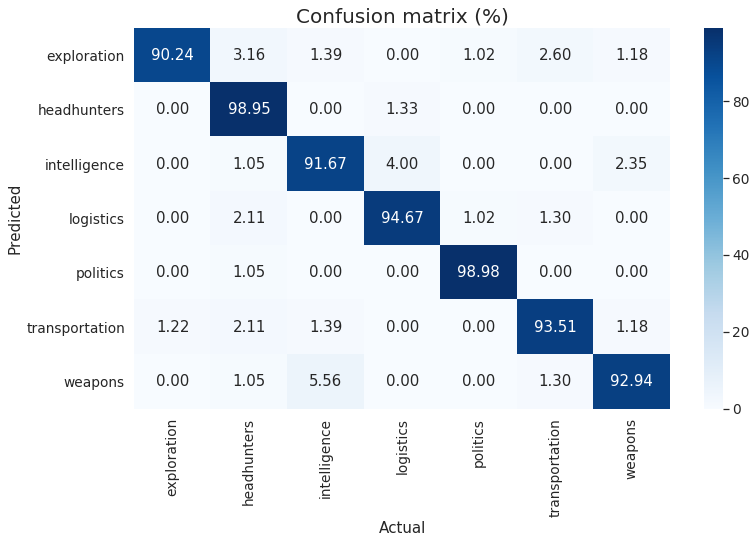

In [40]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'],             
    yticklabels=labels['category'], 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

## 9.2. RandomForest

In [41]:
from sklearn.ensemble import RandomForestClassifier

count_data = count_vectorizer.fit_transform(X_train).toarray()

clf = RandomForestClassifier(
    n_estimators=800,
    max_depth=8, 
    random_state=0
)
clf.fit(count_data, y_train)

test_count_data = count_vectorizer.transform(X_test).toarray()
score = clf.score(test_count_data, y_test)
test_scores = clf.predict(test_count_data)

print("Accuracy: {:.2f}%".format(score*100))

Accuracy: 83.39%


In [42]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)].copy()
    y_test_cat = y_test[y_test.index.isin(idx)].copy()
    test_count_data = count_vectorizer.transform(X_test_cat)

    score = clf.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 97.89%
Accuracy on exploration: 87.80%
Accuracy on weapons: 82.35%
Accuracy on logistics: 80.00%
Accuracy on politics: 90.82%
Accuracy on intelligence: 41.67%
Accuracy on transportation: 94.81%


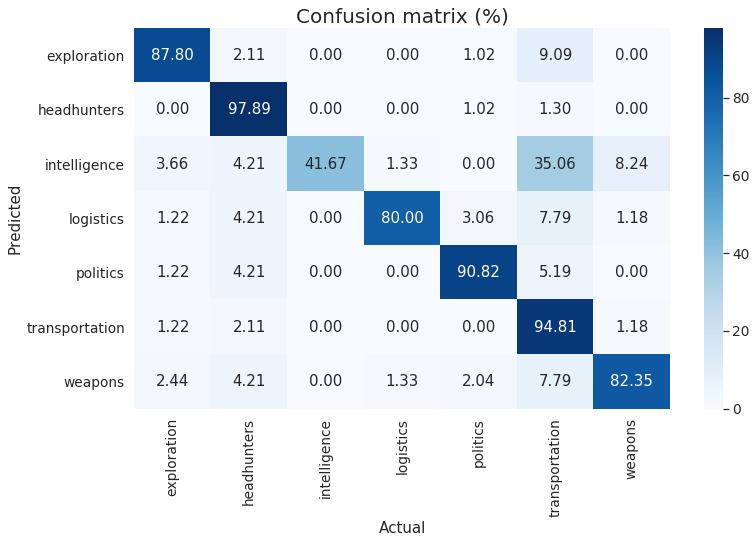

In [43]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'].values,             
    yticklabels=labels['category'].values, 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

## 9.3. Multinomial Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(count_data, y_train)

test_count_data = count_vectorizer.transform(X_test).toarray()
score = clf.score(test_count_data, y_test)
test_scores = clf.predict(test_count_data)

print("Accuracy: {:.2f}%".format(score*100))

Accuracy: 95.72%


In [45]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)].copy()
    y_test_cat = y_test[y_test.index.isin(idx)].copy()
    test_count_data = count_vectorizer.transform(X_test_cat)

    score = clf.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 97.89%
Accuracy on exploration: 96.34%
Accuracy on weapons: 92.94%
Accuracy on logistics: 97.33%
Accuracy on politics: 96.94%
Accuracy on intelligence: 93.06%
Accuracy on transportation: 94.81%


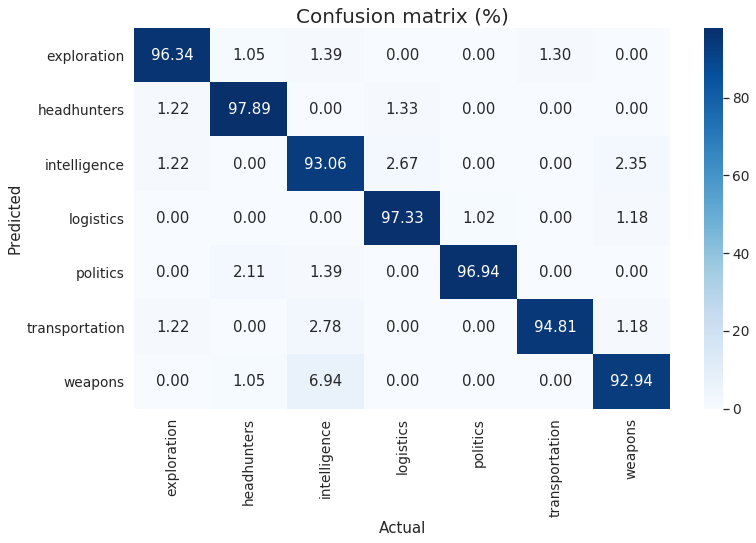

In [47]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'].values,             
    yticklabels=labels['category'].values, 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

# 10. Features based on TF-IDF for text representation

At this point we create features for text based on TF-IDF values. This metric combine TF which means term frequency, so it basically provide the proportion of one word in a text over total words in it. It kind of show how relevant is the word in that text. The other part, IDF is a measure of how much information a word provides. This is important due to extremely usual terms that may appear and they do not provide useful information to distinguish between relevant or not relevant text. 

In [48]:
ngram_range = (1,3)
min_df = 20
max_df = 1.
max_features = None

In [49]:
tfidf = TfidfVectorizer(encoding='latin1',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)#.toarray()
labels_train = y_train
print(features_train.shape)

(3309, 3660)


In [50]:
# Helper function
def plot_10_most_relevant_words_per_category():
    for cat in categories:
        
        idx = data[data['category']==cat].index.tolist()
        X_train_cat = X_train[X_train.index.isin(idx)]
        count_data = tfidf.fit_transform(X_train_cat)
        
        import matplotlib.pyplot as plt
        words = tfidf.get_feature_names()
        total_counts = np.zeros(len(words))
        for t in count_data:
            total_counts+=t.toarray()[0]
        
        count_dict = (zip(words, total_counts))
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
        words = [w[0] for w in count_dict]
        counts = [w[1] for w in count_dict]
        x_pos = np.arange(len(words)) 
        
        print(cat)
        plt.figure(2, figsize=(15, 15/1.6180))
        plt.subplot(title='10 most relevant words')
        sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
        sns.barplot(x_pos, counts, palette='husl')
        plt.xticks(x_pos, words, rotation=90) 
        plt.xlabel('words')
        plt.ylabel('relevance')
        plt.show()

headhunters


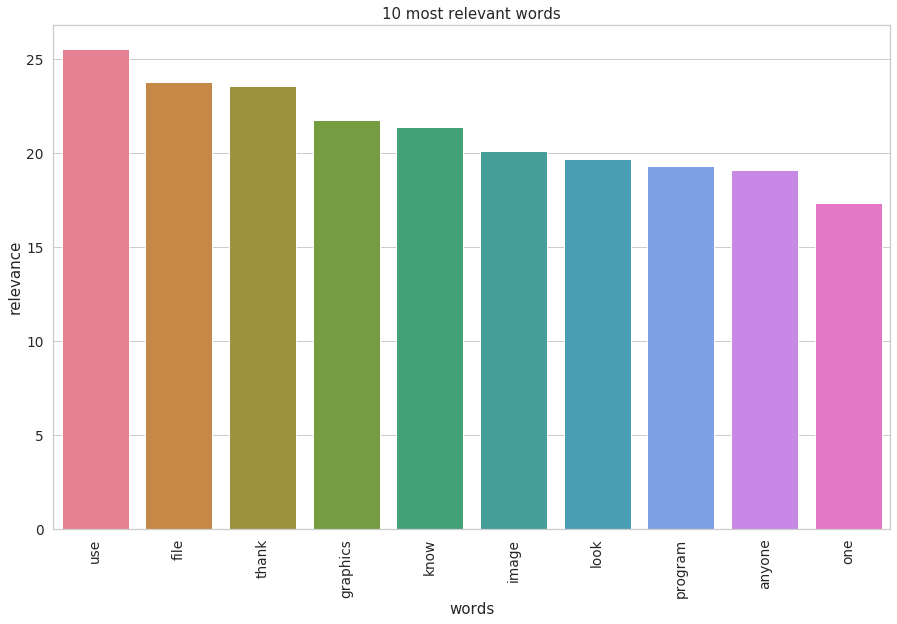

exploration


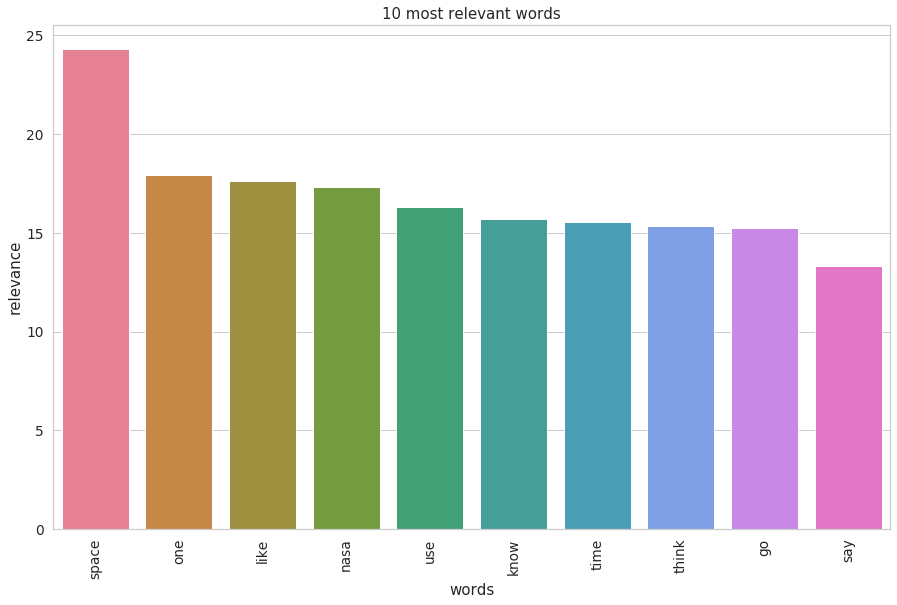

weapons


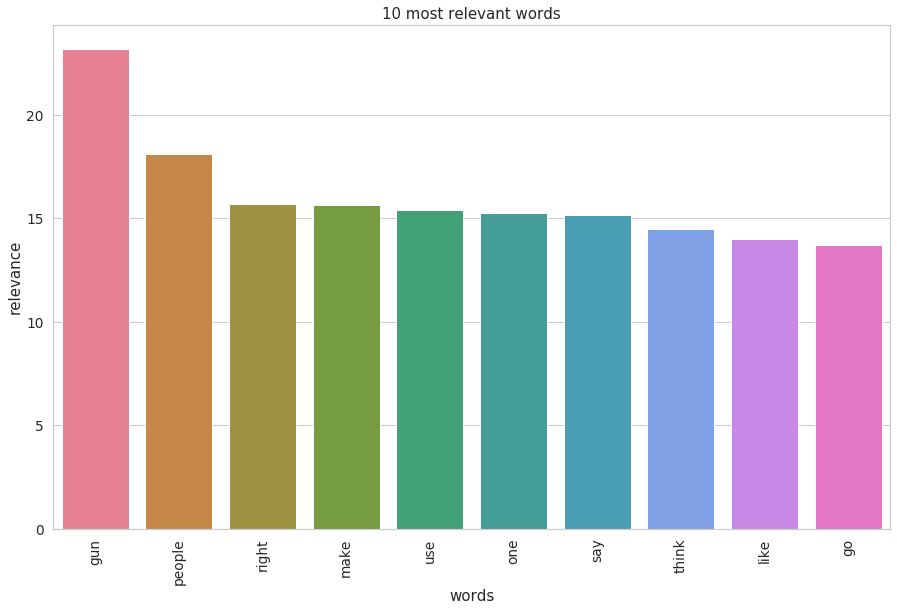

logistics


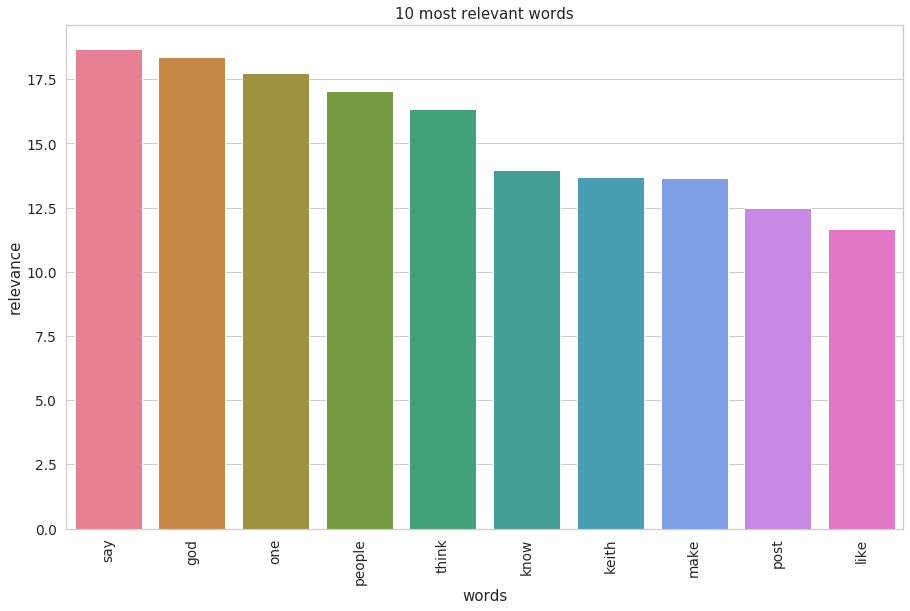

politics


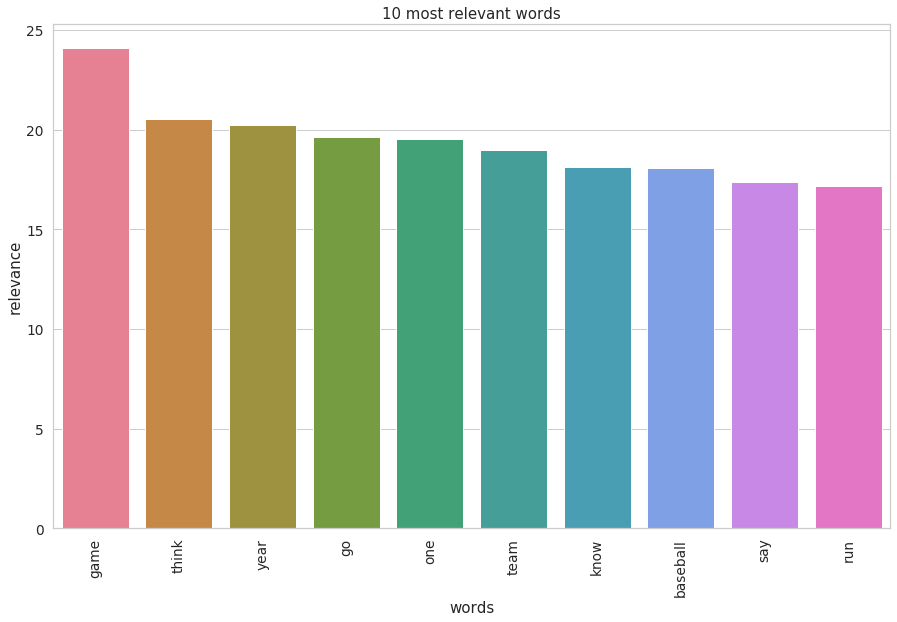

intelligence


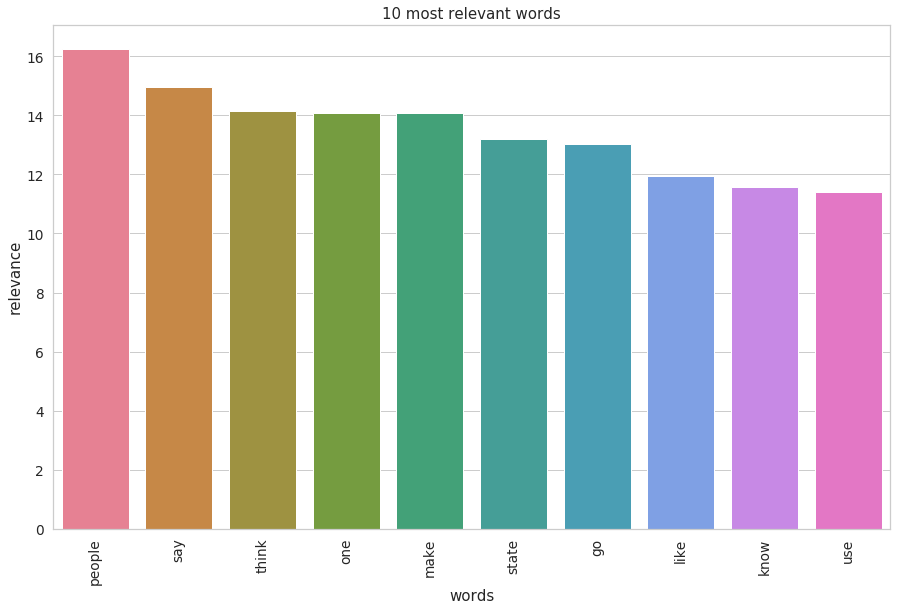

transportation


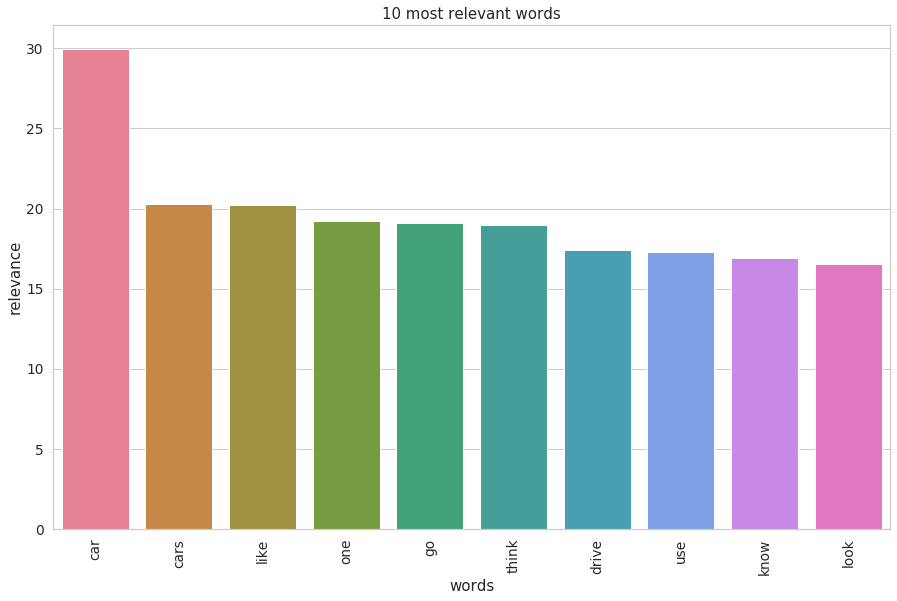

In [51]:
plot_10_most_relevant_words_per_category()

Now we are going to try multiple models. We could try a lot more includind neural networks but let see this three: logistic regression, random forest and naive bayes

## 10.1. Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

features_train = tfidf.fit_transform(X_train).toarray()

classifier = LogisticRegression(multi_class='ovr')
classifier.fit(features_train, labels_train)
test_tfidf_data = tfidf.transform(X_test).toarray()

score = classifier.score(test_tfidf_data, y_test)
test_scores = classifier.predict(test_tfidf_data)

print("Accuracy: {:.2f}%".format(score*100))

/home/dario/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 91.95%


In [53]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)].copy()
    y_test_cat = y_test[y_test.index.isin(idx)].copy()
    test_count_data = tfidf.transform(X_test_cat)

    score = classifier.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 94.74%
Accuracy on exploration: 92.68%
Accuracy on weapons: 87.06%
Accuracy on logistics: 89.33%
Accuracy on politics: 96.94%
Accuracy on intelligence: 87.50%
Accuracy on transportation: 93.51%


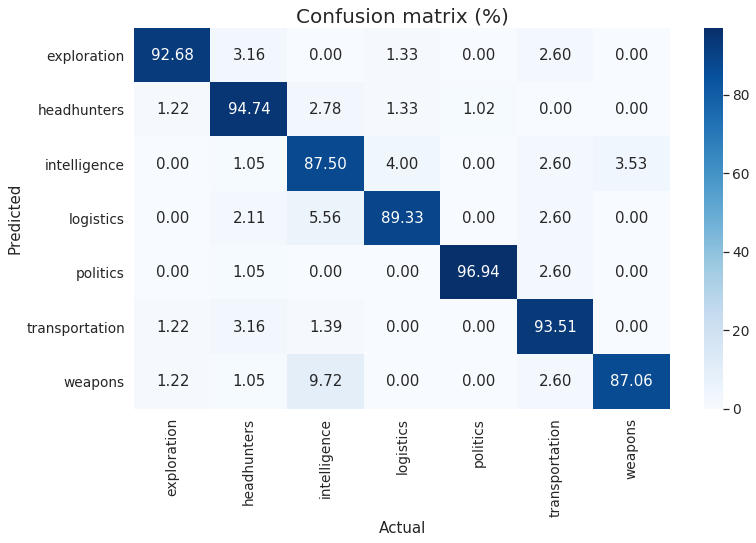

In [54]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'].values,             
    yticklabels=labels['category'].values, 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

## 10.2. RandomForest

In [61]:
from sklearn.ensemble import RandomForestClassifier

features_train = tfidf.fit_transform(X_train).toarray()

clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=8, 
    random_state=0
)
clf.fit(features_train, y_train)

test_tfidf_data = tfidf.transform(X_test).toarray()
score = clf.score(test_tfidf_data, y_test)
test_scores = clf.predict(test_tfidf_data)

print("Accuracy: {:.2f}%".format(score*100))

Accuracy: 83.39%


In [62]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)].copy()
    y_test_cat = y_test[y_test.index.isin(idx)].copy()
    test_count_data = tfidf.transform(X_test_cat)

    score = clf.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 92.63%
Accuracy on exploration: 89.02%
Accuracy on weapons: 78.82%
Accuracy on logistics: 84.00%
Accuracy on politics: 89.80%
Accuracy on intelligence: 54.17%
Accuracy on transportation: 89.61%


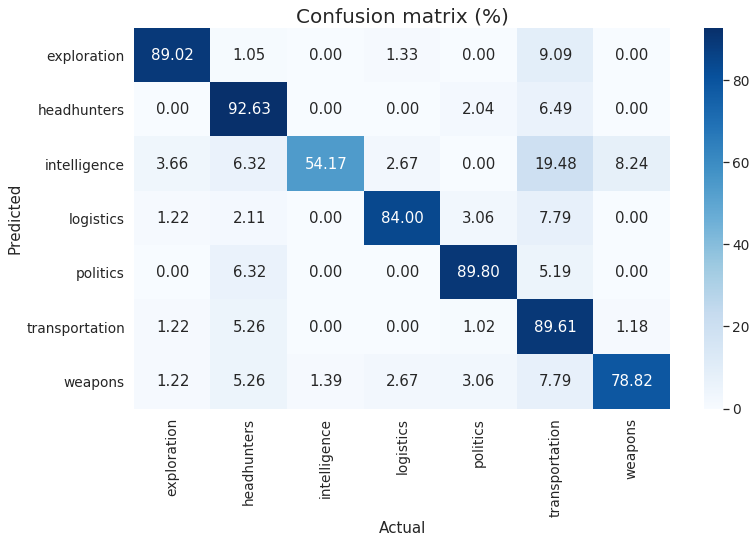

In [63]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'].values,             
    yticklabels=labels['category'].values, 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

## 10.3. Multinomial Naive Bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB

features_train = tfidf.fit_transform(X_train).toarray()

clf = MultinomialNB()
clf.fit(features_train, y_train)

test_tfidf_data = tfidf.transform(X_test).toarray()
score = clf.score(test_tfidf_data, y_test)
test_scores = clf.predict(test_tfidf_data)

print("Accuracy: {:.2f}%".format(score*100))

Accuracy: 91.10%


In [65]:
for cat in categories:
    idx = data[data['category']==cat].index.tolist()
    X_test_cat = X_test[X_test.index.isin(idx)].copy()
    y_test_cat = y_test[y_test.index.isin(idx)].copy()
    test_count_data = tfidf.transform(X_test_cat)

    score = clf.score(test_count_data, y_test_cat)

    print("Accuracy on {}: {:.2f}%".format(cat, score*100))

Accuracy on headhunters: 95.79%
Accuracy on exploration: 90.24%
Accuracy on weapons: 89.41%
Accuracy on logistics: 86.67%
Accuracy on politics: 95.92%
Accuracy on intelligence: 81.94%
Accuracy on transportation: 94.81%


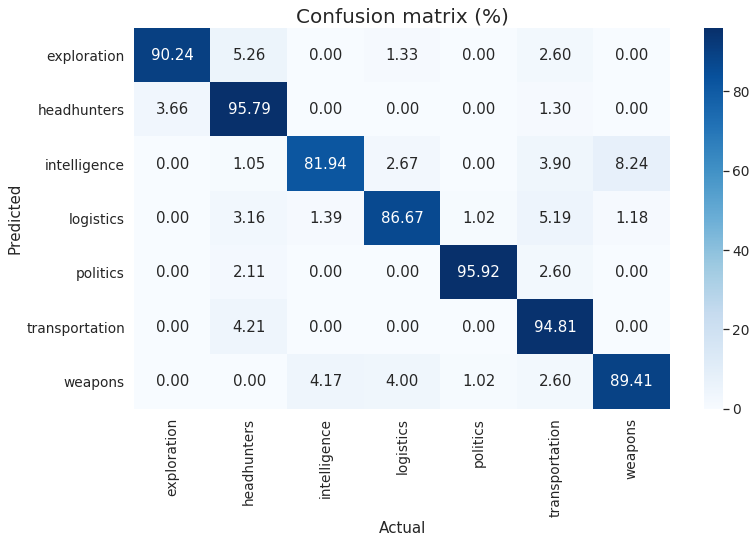

In [66]:
labels = data[['category', 'category_label']].drop_duplicates().sort_values('category')

conf_matrix = confusion_matrix(y_test, test_scores)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1) * 100

plt.figure(figsize=(12,7))
sns.heatmap(
    conf_matrix,      
    annot=True,            
    xticklabels=labels['category'].values,             
    yticklabels=labels['category'].values, 
    fmt='.2f',
    cmap="Blues",
    #square=True
)
plt.ylim(7,0)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix (%)', fontsize=20)
plt.show()

# 11. Select best model

Best model is Multinomial Naive Bayes with CountVectorizer technique for text repesentation with total accuracy of 95.72% and accuracies for every category above 92.94%